In [2]:
import tensorflow as tf

def euclideanDistance(x, z):
    y = x-z
    distance = tf.transpose(y)*(y)
    return distance

def euclideanDistanceMultipleDimension(A,B):
    r = tf.reduce_sum(A*A, 1)
    d = tf.reduce_sum(B*B,1)
    d = tf.reshape(d, [-1, 1])
    #print (d.shape)
    r = tf.reshape(r, [-1, 1])
    #print (r.shape)

    #print (sess.run(r))
    
    #print (sess.run(d))
    
    #print (sess.run(2*tf.matmul(A, tf.transpose(B))))
    
    D = r - 2*tf.matmul(A, tf.transpose(B)) + tf.transpose(d)
    return D

def euclideanV3(x,z):
    #get the dimension of z,x 
    z_dim = tf.shape(z) #z_dim[0] = num of rows, z_dim[1] = num of columns
    z_row = z_dim[0]
    z_col = z_dim[1]
    x_dim = tf.shape(x) 
    x_row = x_dim[0]
    x_col = x_dim[1]
    
    #duplicate each row in x by z_row times
    x_expanded = tf.tile(x,[1,z_row],name='x_expanded') #note this is a flattend array
    #print (sess.run(x_expanded))
    # get the desired shape 
    x_reshaped = tf.reshape(x_expanded,[x_row,z_row,z_col])
    #print (sess.run(x_reshaped))
    
    #get the square of the difference, tensorflow broadcasts z to match the size of s
    square_difference = tf.square(x_reshaped-z)
    #reduce sum each row
    #print (sess.run(square_difference))
    d = tf.reduce_sum(square_difference,2)
    return d
    

#part3 Load Data
def data_segmentation(data_path, target_path, task):
# task = 0 >> select the name ID targets for face recognition task
# task = 1 >> select the gender ID targets for gender recognition task
        data = np.load(data_path)/255
        data = np.reshape(data, [-1, 32*32])
        target = np.load(target_path)
        np.random.seed(45689)
        rnd_idx = np.arange(np.shape(data)[0])
        np.random.shuffle(rnd_idx)
        trBatch = int(0.8*len(rnd_idx))
        validBatch = int(0.1*len(rnd_idx))
        trainData, validData, testData = data[rnd_idx[1:trBatch],:], \
        data[rnd_idx[trBatch+1:trBatch + validBatch],:],\
        data[rnd_idx[trBatch + validBatch+1:-1],:]
        trainTarget, validTarget, testTarget = target[rnd_idx[1:trBatch], task], \
        target[rnd_idx[trBatch+1:trBatch + validBatch], task],\
        target[rnd_idx[trBatch + validBatch + 1:-1], task]
        return trainData, validData, testData, trainTarget, validTarget, testTarget


trainData, validData, testData, trainTarget, validTarget, testTarget=data_segmentation("data.npy")
    
a = tf.constant([1,1,1,1], name='a')
b = tf.constant([2,5,2,2],name='b')
c = euclideanDistance(a,b)
   
sess = tf.InteractiveSession()
init = tf.global_variables_initializer()
sess.run(init)

A = tf.constant([[1, 1], [2, 2], [3, 3],[4,4]])
B= tf.constant ([[4,4],[5,5],[6,6],[4,4]])
D= euclideanDistanceMultipleDimension(A,B)
print(sess.run([D]))

/Users/zeyang/.virtualenvs/cv/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


[array([[18, 32, 50, 18],
       [ 8, 18, 32,  8],
       [ 2,  8, 18,  2],
       [ 0,  2,  8,  0]], dtype=int32)]


[[ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.33333334
   0.          0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.33333334]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.33333334  0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.          0.          0.
   0.          0.          0.        ]
 [ 0.          0.          0.          0.          0.   

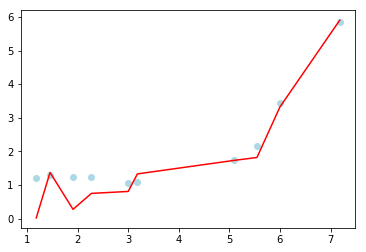

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import itertools

np.random.seed(521)
Data = np.linspace(1.0 , 10.0 , num =100) [:, np. newaxis]
Target = np.sin( Data ) + 0.1 * np.power( Data , 2) \
+ 0.5 * np.random.randn(100 , 1)
randIdx = np.arange(100)
np.random.shuffle(randIdx)
trainData, trainTarget = Data[randIdx[:80]], Target[randIdx[:80]]
validData, validTarget = Data[randIdx[80:90]], Target[randIdx[80:90]]
testData, testTarget = Data[randIdx[90:100]], Target[randIdx[90:100]]

def findResponsibility(trainMatrix,testMatrix,k):
    distance = euclideanDistanceMultipleDimension(trainMatrix,testMatrix)
    distanceVector = tf.transpose(distance)
    distanceShape = tf.shape(distance)
    smallestIndices = tf.nn.top_k(-distanceVector, k).indices
    hotMatrix = tf.one_hot(smallestIndices, depth=distanceShape[0], on_value = 1/k)
    responsibilityMatrix = tf.transpose(tf.reduce_max(hotMatrix,1))
    responsibilityMatrix = tf.cast(responsibilityMatrix, tf.float64)
    return responsibilityMatrix

responsibility = findResponsibility(trainData,testData,3)
trainTarget = tf.transpose(trainTarget)
print(sess.run(responsibility))
print(sess.run(trainTarget))
y_hat = tf.matmul(trainTarget,responsibility)
# Error definition
mse=tf.losses.mean_squared_error(testTarget,tf.transpose(y_hat))
meanSquaredError = tf.reduce_mean(tf.reduce_sum(tf.square(y_hat - testTarget), 
                                                reduction_indices=1, 
                                                name='squared_error'), 
                                  name='mean_squared_error')



#print(trainData)
#print(testData)
print("y_hat:")
graph_y_hat = tf.reshape(tf.transpose(y_hat),[-1])
print(sess.run(graph_y_hat))
print("test data:")
graph_test_data = tf.reshape(testData,[-1])
graph_test_target = tf.reshape(testTarget,[-1])
print(sess.run(graph_test_data))
print("MSE:")
print(sess.run(mse))
#X = np.linspace(0:0; 11:0;num = 1000)[:; np:newaxis]

lists = sorted(zip(*[sess.run(graph_test_data), sess.run(graph_test_target)]))
new_x, new_y = list(zip(*lists))
print("plot lightblue=prediction,red=expected:")
plt.scatter(sess.run(tf.reshape(testData,[-1])), sess.run(tf.reshape(tf.transpose(y_hat),[-1])), color='lightblue')
plt.plot(new_x, new_y, color='red')
plt.show()




In [217]:
import numpy as np
np.random.seed(521)
Data = np.linspace(1.0 , 10.0 , num =100) [:, np. newaxis]
Target = np.sin( Data ) + 0.1 * np.power( Data , 2) \
+ 0.5 * np.random.randn(100 , 1)
randIdx = np.arange(100)
np.random.shuffle(randIdx)

trainData = np.array([[4],[1],[3],[2],[5]],np.float32)
testData = np.array([[4],[6]],np.float32)
#validData, validTarget = Data[randIdx[80:90]], Target[randIdx[80:90]]
#testData, testTarget = Data[randIdx[90:100]], Target[randIdx[90:100]]
distance = euclideanDistanceMultipleDimension(trainData,testData)
print(sess.run([distance]))

distance_tensor = tf.convert_to_tensor(distance)
distance_flat = tf.transpose(distance_tensor)
print(sess.run(distance_flat))
smallest_k,indices = tf.nn.top_k(-distance_flat,2)
indices=sess.run(indices)
resp=tf.reduce_sum(tf.one_hot(indices,depth=tf.shape()[0],on_value=1/2),1)
print (sess.run(resp))
print("hehhh")
print(sess.run(smallest_k))
kth = tf.reduce_min(smallest_k.values,axis=1)
print(sess.run(tf.shape(kth)))
kth = tf.reshape(kth,[1,2])
print(sess.run(kth))
kth = tf.negative(kth)
print(sess.run(kth))

distance_bool = distance <= kth
print(sess.run(distance_bool))
#idx = sess.run(smallest_k.indices)
#a = tf.gather(distance_flat,smallest_k.indices)
#print(sess.run(a))
#print(idx)
#distance_flat[idx] = 1/3
#small_print.assign(small_print,1/3,small.indices)

#_, idx = s.run(tf.nn.top_k(-1*dist, k=k))
#print(idx)
#zeros = sess.run(tf.zeros(tf.shape(distance), dtype=tf.float64))
#zeros[[0 0][0 2][1 4][1 0]] = 1.0/2

#print(zeros)


[array([[ 0.,  4.],
       [ 9., 25.],
       [ 1.,  9.],
       [ 4., 16.],
       [ 1.,  1.]], dtype=float32)]
[[ 0.  9.  1.  4.  1.]
 [ 4. 25.  9. 16.  1.]]


TypeError: shape() missing 1 required positional argument: 'input'

In [232]:
trainData = np.array([[4],[1],[3],[2],[5]],np.float32)
testData = np.array([[4],[6]],np.float32)


distance = euclideanDistanceMultipleDimension(trainData,testData)
print(sess.run([distance]))

#distanceVector = tf.reshape(distance, [1, tf.size(distance)])
distanceVector = tf.transpose(distance)
shape = tf.shape(distance)
topIndices = tf.nn.top_k(-distanceVector, 2).indices
#topIndices = tf.constant ([0,1])
print(sess.run(topIndices))
#responsibilityVector = tf.matrix_transpose(tf.zeros_like(tf.squeeze(distanceVector))).eval(session=sess)
#responsibilityVector[0:4][topIndices.eval(session=sess)]= tf.divide(1, 2)
#responsibilityMatrix = tf.reshape(responsibilityVector, tf.shape(distance))
hotMatrix = tf.one_hot(topIndices,depth=5,on_value = 1)
responsibilityMatrix = tf.transpose(tf.reduce_max(hotMatrix,1))
#tf.convert_to_tensor(responsibilityMatrix)
print(sess.run(hotMatrix))
print(sess.run(responsibilityMatrix))

[array([[ 0.,  4.],
       [ 9., 25.],
       [ 1.,  9.],
       [ 4., 16.],
       [ 1.,  1.]], dtype=float32)]
[[0 2]
 [4 0]]
[[[1 0 0 0 0]
  [0 0 1 0 0]]

 [[0 0 0 0 1]
  [1 0 0 0 0]]]
[[1 1]
 [0 0]
 [1 0]
 [0 0]
 [0 1]]


In [ ]:
#part3 Load Data
def data_segmentation(data_path, target_path, task):
# task = 0 >> select the name ID targets for face recognition task
# task = 1 >> select the gender ID targets for gender recognition task
        data = np.load(data_path)/255
        data = np.reshape(data, [-1, 32*32])
        target = np.load(target_path)
        np.random.seed(45689)
        rnd_idx = np.arange(np.shape(data)[0])
        np.random.shuffle(rnd_idx)
        trBatch = int(0.8*len(rnd_idx))
        validBatch = int(0.1*len(rnd_idx))
        trainData, validData, testData = data[rnd_idx[1:trBatch],:], \
        data[rnd_idx[trBatch+1:trBatch + validBatch],:],\
        data[rnd_idx[trBatch + validBatch+1:-1],:]
        trainTarget, validTarget, testTarget = target[rnd_idx[1:trBatch], task], \
        target[rnd_idx[trBatch+1:trBatch + validBatch], task],\
        target[rnd_idx[trBatch + validBatch + 1:-1], task]
        return trainData, validData, testData, trainTarget, validTarget, testTarget






































































































































































































